In [1]:
import EOSutils as meos

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable


mpl.style.use('classic')

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

import mesa_helper as mh
import os
import shutil
import copy

from scipy import interpolate,ndimage
from scipy.linalg import lstsq as scipy_lstsq
from scipy.ndimage import gaussian_filter
import scipy.integrate as integrate
import decimal 

%matplotlib inline

In [2]:
profiles = meos.load_sample_planet_profiles(Minit=np.array((1.09,7.59,20.0)), Rinit=2.0, Zinit=0.025, comps=['uniform','inert_core'], Sinit=np.array((9.0,11.0)), alphas=2.0, ages=np.array((1.e6,1.e10)))


In [157]:
# set control params
smoothing_kernel = 10
scaling_fac = 0.05

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/2041323012.py:3: RuntimeWarning: overflow encountered in power
  meos.plot_PSE(cms19_H, 10**cms19_H.log10Pgrid,10**cms19_H.log10Sgrid,10**cms19_H.log10Ugrid,plot_tracks=True)


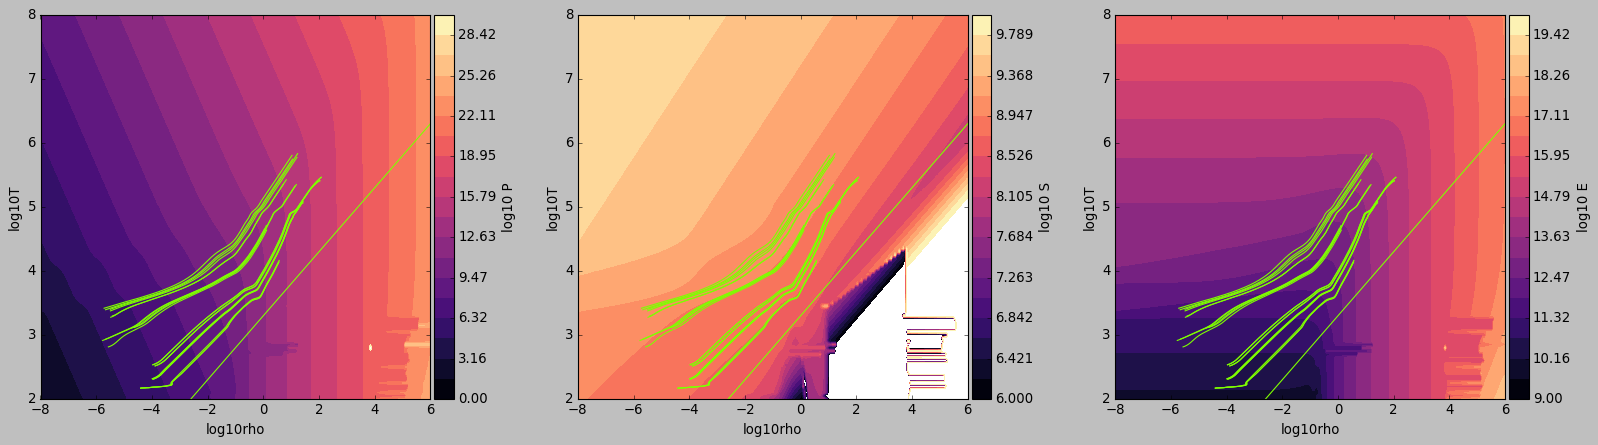

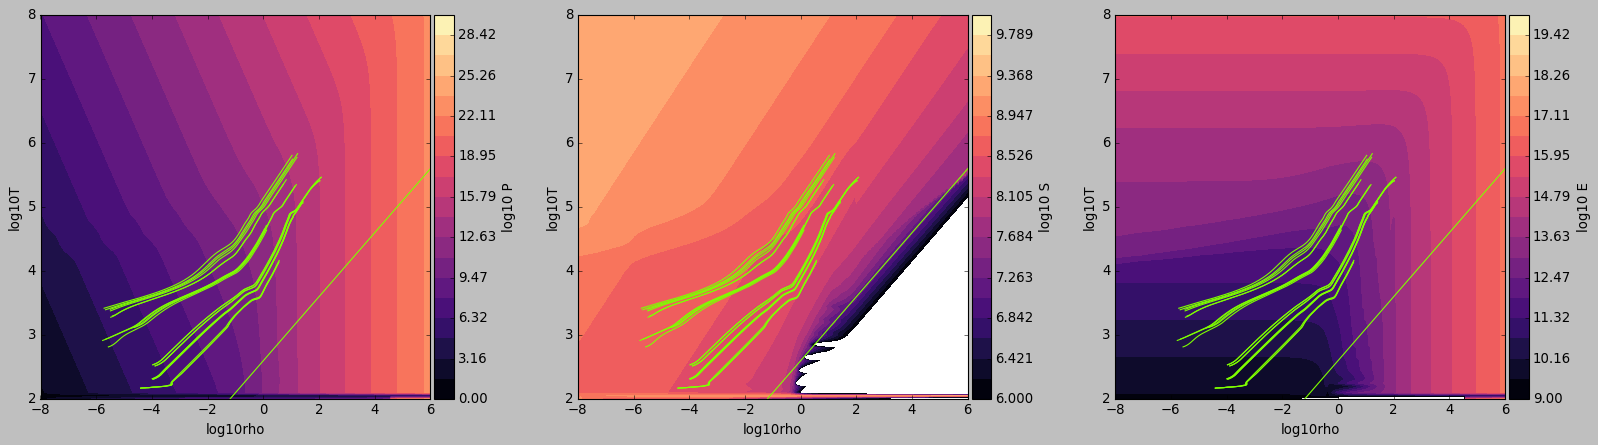

In [158]:
cms19_H = meos.CMStable("../2021_chabrier+_tables/TABLE_H_Trho_v1",units='cgs')
cms19_H.compute_F_table(F_smoothing_kernel=smoothing_kernel, F_nan_fill_value=None)
meos.plot_PSE(cms19_H, 10**cms19_H.log10Pgrid,10**cms19_H.log10Sgrid,10**cms19_H.log10Ugrid,plot_tracks=True)

cms19_He = meos.CMStable("../2021_chabrier+_tables/TABLE_HE_Trho_v1",units='cgs',F_smoothing_kernel=smoothing_kernel)
new_P, new_S, new_E = meos.interpolate_problematic_values(cms19_He,bad_rho_idxs=np.arange(193,203), bad_T_idxs=[79,80,81])
cms19_He.log10Ptable = new_P
cms19_He.log10Stable = new_S
cms19_He.log10Etable = new_E
cms19_He.compute_F_table(F_smoothing_kernel=smoothing_kernel, F_nan_fill_value=None)
meos.plot_PSE(cms19_He, 10**cms19_He.log10Pgrid,10**cms19_He.log10Sgrid,10**cms19_He.log10Egrid,plot_tracks=True)

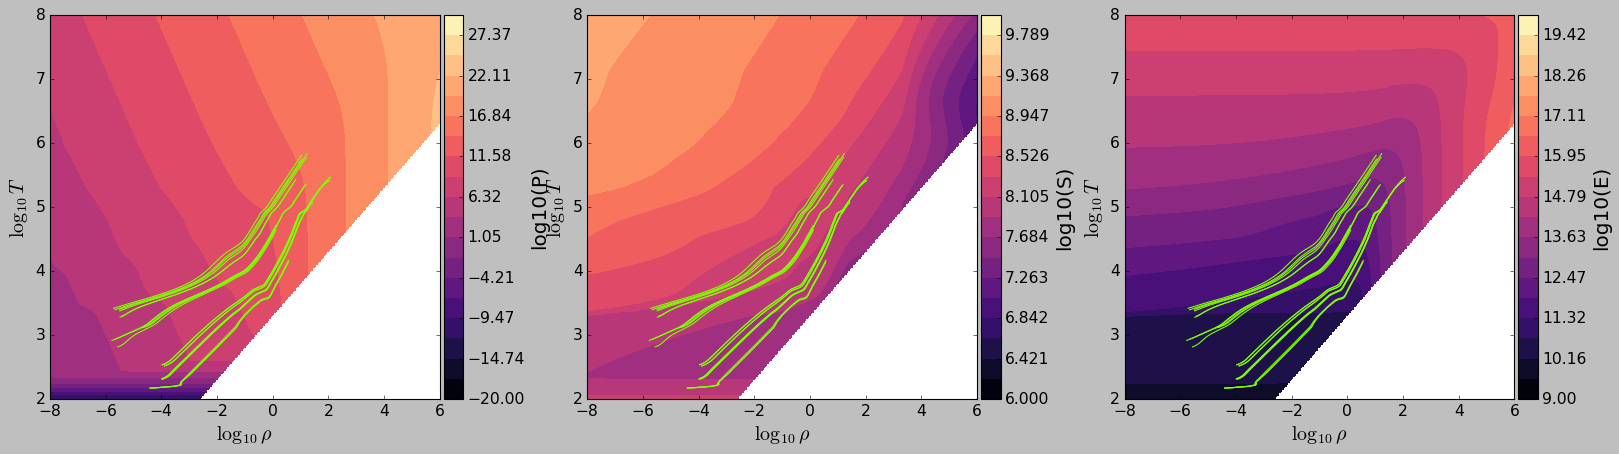

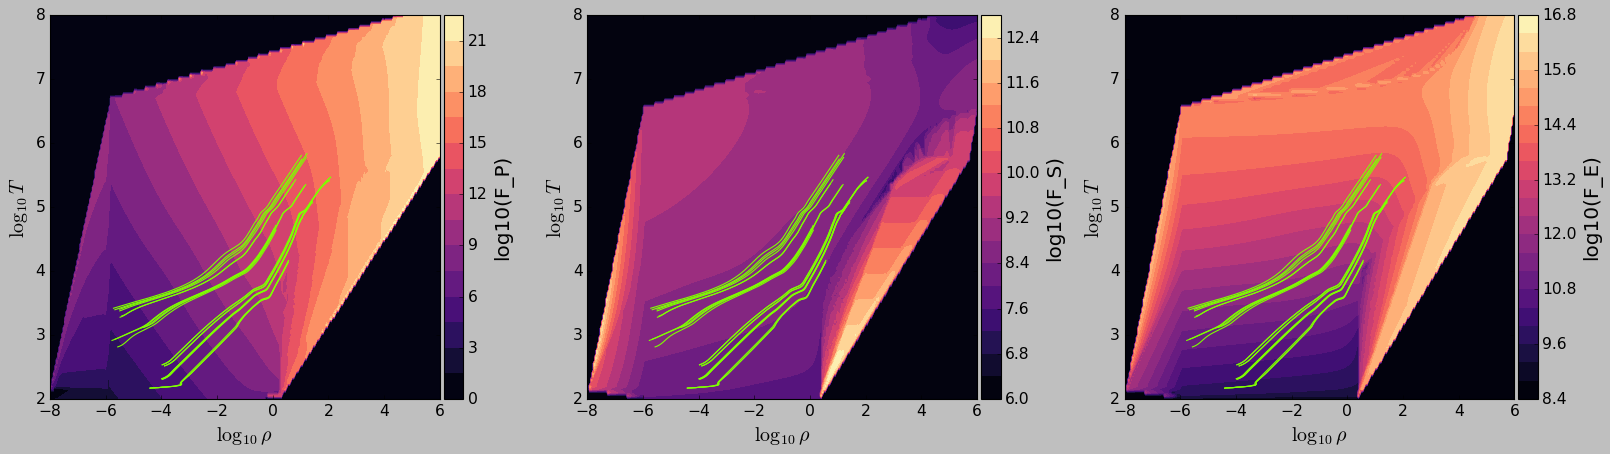

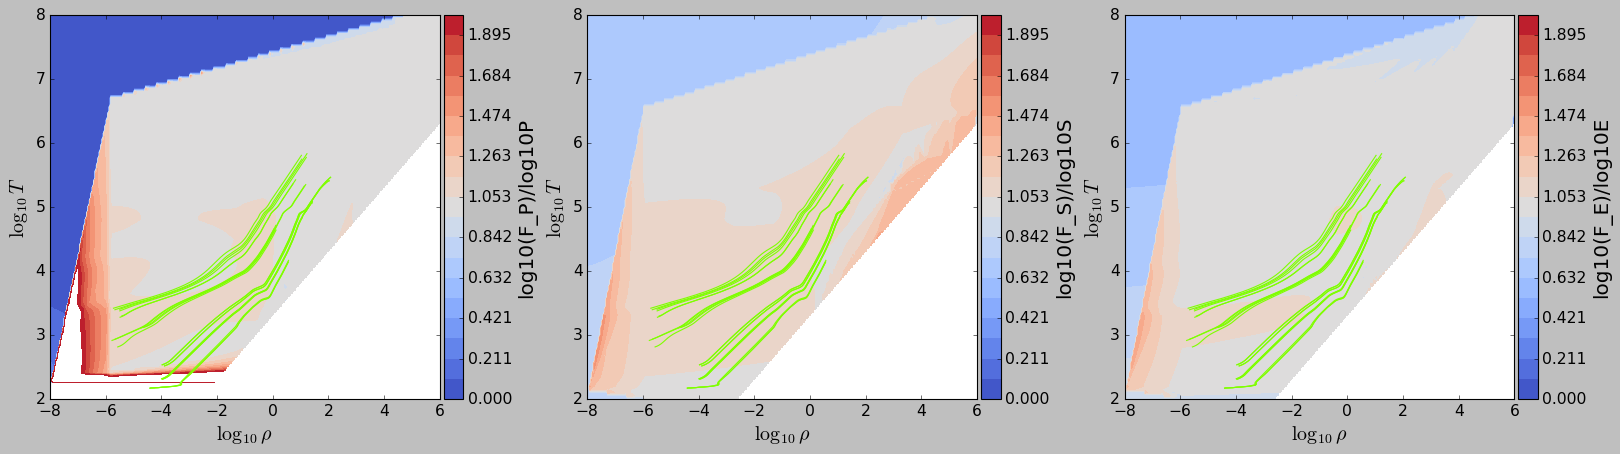

In [159]:
my_Z = meos.read_MESAtable("../my_MESAformat_tables/mesa-planetblend_100z00x.data")
my_Z_Trho = meos.reshapeQTgrid(my_Z,-8,6)
#print(type(my_Z_Trho))
#print(np.shape(my_Z_Trho))

Z = meos.simple_table()
Z.X = 0.
Z.Y = 0.
Z.Z = 1.

Z.log10Tgrid = my_Z_Trho[:,:,0].T
Z.log10rhogrid = my_Z_Trho[:,:,-1].T

Z.log10Pgrid = my_Z_Trho[:,:,1].T
Z.log10Sgrid = my_Z_Trho[:,:,3].T
Z.log10Ugrid = my_Z_Trho[:,:,2].T
Z.log10Egrid = Z.log10Ugrid

Z.compute_atomic_number()
Z.compute_F_table(F_smoothing_kernel=smoothing_kernel, F_nan_fill_value='reflect')

# eliminate very small values that are yielding nans
#Z.F_Pgrid[(Z.F_Pgrid <= 0.) & (np.abs(Z.F_Pgrid) <= 1)] = 1
nanmask = (Z.F_Pgrid <= 0.) | (Z.F_Sgrid <= 0.) | (Z.F_Egrid <= 0.)
Z.F_Pgrid[nanmask] = np.nan
Z.F_Sgrid[nanmask] = np.nan
Z.F_Egrid[nanmask] = np.nan
Z.F_Pgrid = meos.fill_in_nans(Z.F_Pgrid, Z, fill_value=np.min(Z.F_Pgrid[~np.isnan(Z.F_Pgrid)]))
Z.F_Sgrid = meos.fill_in_nans(Z.F_Sgrid, Z, fill_value=np.min(Z.F_Sgrid[~np.isnan(Z.F_Sgrid)]))
Z.F_Egrid = meos.fill_in_nans(Z.F_Egrid, Z, fill_value=np.min(Z.F_Egrid[~np.isnan(Z.F_Egrid)]))

Z.F_log10Pgrid = np.log10(Z.F_Pgrid)
Z.F_log10Sgrid = np.log10(Z.F_Sgrid)
Z.F_log10Egrid = np.log10(Z.F_Egrid)

meos.contourf_sublots_with_colorbars(nRow=1, nCol=3, 
                                xs=Z.log10rhogrid,
                                ys=Z.log10Tgrid,
                                zs=[Z.log10Pgrid,Z.log10Sgrid,Z.log10Ugrid],
                                xlims=(-8,6),
                                ylims=(2,8),
                                zlims=[(-20,30),(6,10),(9,20)],
                                levels=20,
                                xlabels=r'$\log_{10}\rho$',
                                ylabels=r'$\log_{10}T$',
                                zlabels=['log10(P)','log10(S)','log10(E)'],
                                cmap='magma', vlines=None, hlines=None, otherlines_x=[prof['logRho'] for prof in profiles], otherlines_y=[prof['logT'] for prof in profiles], 
                                species='Z', plot_interpolation_lines=False, savename=None)

meos.contourf_sublots_with_colorbars(nRow=1, nCol=3, 
                                xs=Z.log10rhogrid,
                                ys=Z.log10Tgrid,
                                zs=[np.log10(Z.F_Pgrid),np.log10(Z.F_Sgrid),np.log10(Z.F_Egrid)],
                                xlims=(-8,6),
                                ylims=(2,8),
                                #zlims=[(-20,30),(6,10),(9,20)],
                                zlims=None,
                                levels=20,
                                xlabels=r'$\log_{10}\rho$',
                                ylabels=r'$\log_{10}T$',
                                zlabels=['log10(F_P)','log10(F_S)','log10(F_E)'],
                                cmap='magma', vlines=None, hlines=None, otherlines_x=[prof['logRho'] for prof in profiles], otherlines_y=[prof['logT'] for prof in profiles], 
                                species='Z', plot_interpolation_lines=False, savename=None)



meos.contourf_sublots_with_colorbars(nRow=1, nCol=3, 
                                xs=Z.log10rhogrid,
                                ys=Z.log10Tgrid,
                                zs=[np.log10(Z.F_Pgrid)/Z.log10Pgrid,np.log10(Z.F_Sgrid)/Z.log10Sgrid,np.log10(Z.F_Egrid)/Z.log10Egrid],
                                xlims=(-8,6),
                                ylims=(2,8),
                                zlims=(0.,2),
                                #zlims=None,
                                levels=20,
                                xlabels=r'$\log_{10}\rho$',
                                ylabels=r'$\log_{10}T$',
                                zlabels=['log10(F_P)/log10P','log10(F_S)/log10S','log10(F_E)/log10E'],
                                cmap='coolwarm', vlines=None, hlines=None, otherlines_x=[prof['logRho'] for prof in profiles], otherlines_y=[prof['logT'] for prof in profiles], 
                                species='Z', plot_interpolation_lines=False, savename=None)


# what if "control" EoS were exactly the same distance away from the original as the F version, but in the other direction?

In [160]:
cms19_H_P_diff = cms19_H.F_Pgrid - 10**cms19_H.log10Pgrid
cms19_H_S_diff = cms19_H.F_Sgrid - 10**cms19_H.log10Sgrid
cms19_H_E_diff = cms19_H.F_Egrid - 10**cms19_H.log10Egrid

cms19_He_P_diff = cms19_He.F_Pgrid - 10**cms19_He.log10Pgrid
cms19_He_S_diff = cms19_He.F_Sgrid - 10**cms19_He.log10Sgrid
cms19_He_E_diff = cms19_He.F_Egrid - 10**cms19_He.log10Egrid

Z_P_diff = Z.F_Pgrid - 10**Z.log10Pgrid
Z_S_diff = Z.F_Sgrid - 10**Z.log10Sgrid
Z_E_diff = Z.F_Egrid - 10**Z.log10Egrid


/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/3499339626.py:2: RuntimeWarning: overflow encountered in power
  cms19_H_S_diff = cms19_H.F_Sgrid - 10**cms19_H.log10Sgrid
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/3499339626.py:3: RuntimeWarning: overflow encountered in power
  cms19_H_E_diff = cms19_H.F_Egrid - 10**cms19_H.log10Egrid


/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/206786152.py:7: RuntimeWarning: invalid value encountered in log10
  control_H.log10Pgrid = np.log10( 10**cms19_H.log10Pgrid - scaling_fac*cms19_H_P_diff )
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/206786152.py:8: RuntimeWarning: overflow encountered in power
  control_H.log10Sgrid = np.log10( 10**cms19_H.log10Sgrid - scaling_fac*cms19_H_S_diff )
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/206786152.py:8: RuntimeWarning: invalid value encountered in log10
  control_H.log10Sgrid = np.log10( 10**cms19_H.log10Sgrid - scaling_fac*cms19_H_S_diff )
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/206786152.py:9: RuntimeWarning: overflow encountered in power
  control_H.log10Ugrid = np.log10( 10**cms19_H.log10Egrid - scaling_fac*cms19_H_E_diff )
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/206786152.py:9: RuntimeWarning: invalid value encountered in 

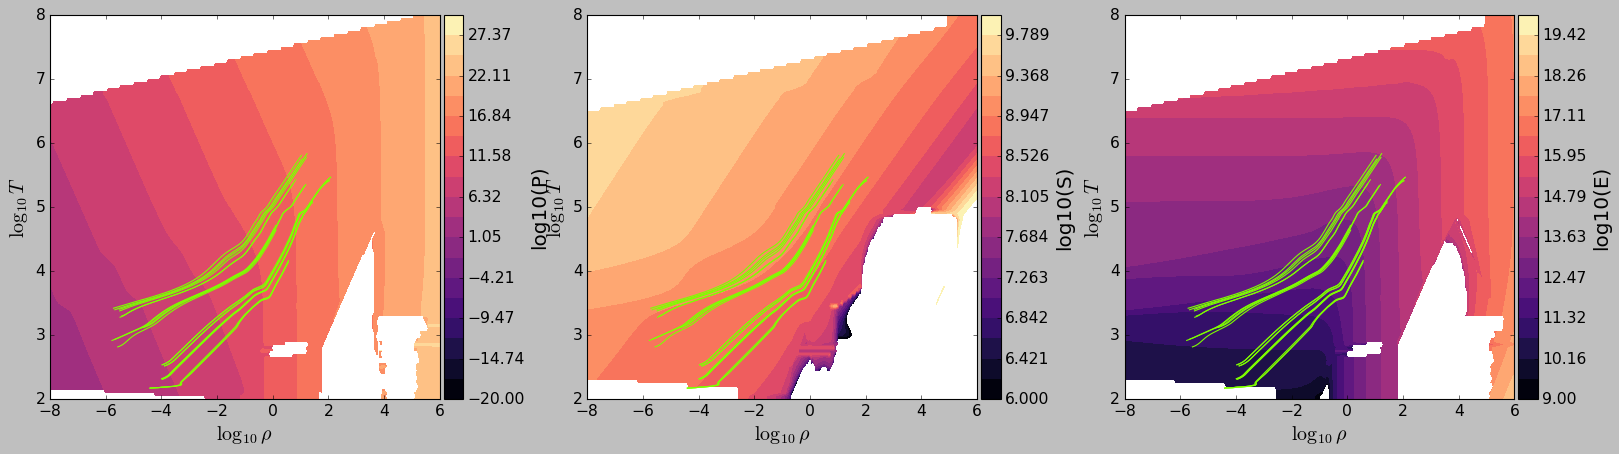

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/206786152.py:35: RuntimeWarning: invalid value encountered in log10
  control_He.log10Pgrid = np.log10( 10**cms19_He.log10Pgrid - scaling_fac*cms19_He_P_diff )
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/206786152.py:36: RuntimeWarning: invalid value encountered in log10
  control_He.log10Sgrid = np.log10( 10**cms19_He.log10Sgrid - scaling_fac*cms19_He_S_diff )
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/206786152.py:37: RuntimeWarning: invalid value encountered in log10
  control_He.log10Ugrid = np.log10( 10**cms19_He.log10Egrid - scaling_fac*cms19_He_E_diff )


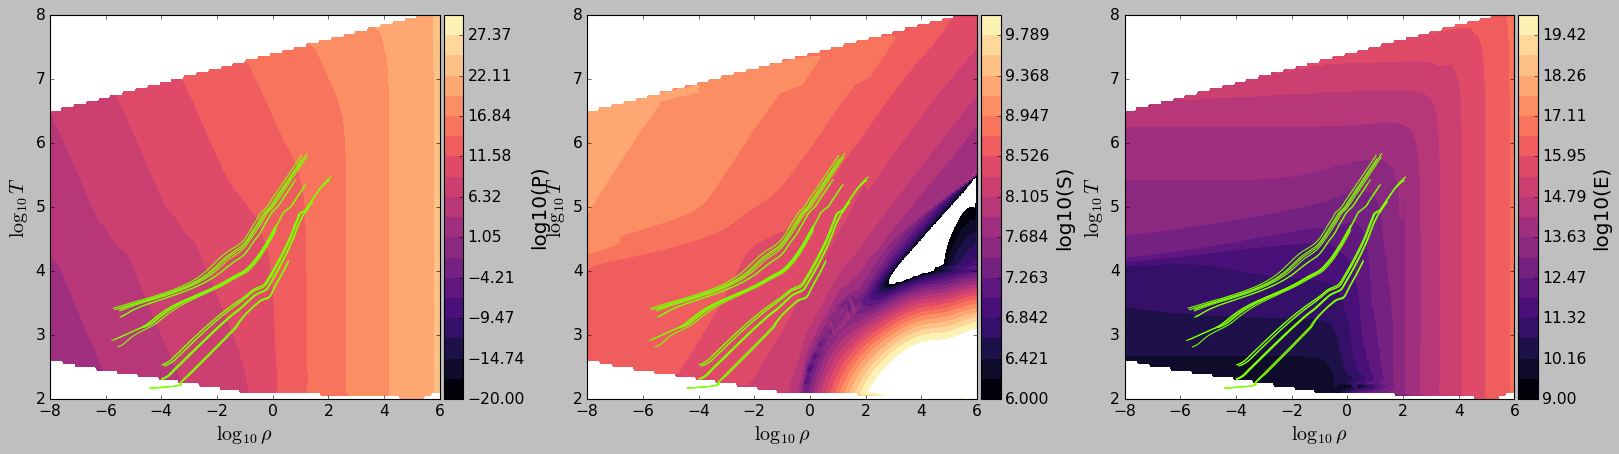

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/206786152.py:71: RuntimeWarning: invalid value encountered in log10
  control_Z.log10Pgrid = np.log10( 10**Z.log10Pgrid - scaling_fac*Z_P_diff )
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/206786152.py:72: RuntimeWarning: invalid value encountered in log10
  control_Z.log10Sgrid = np.log10( 10**Z.log10Sgrid - scaling_fac*Z_S_diff )
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/206786152.py:73: RuntimeWarning: invalid value encountered in log10
  control_Z.log10Ugrid = np.log10( 10**Z.log10Egrid - scaling_fac*Z_E_diff )


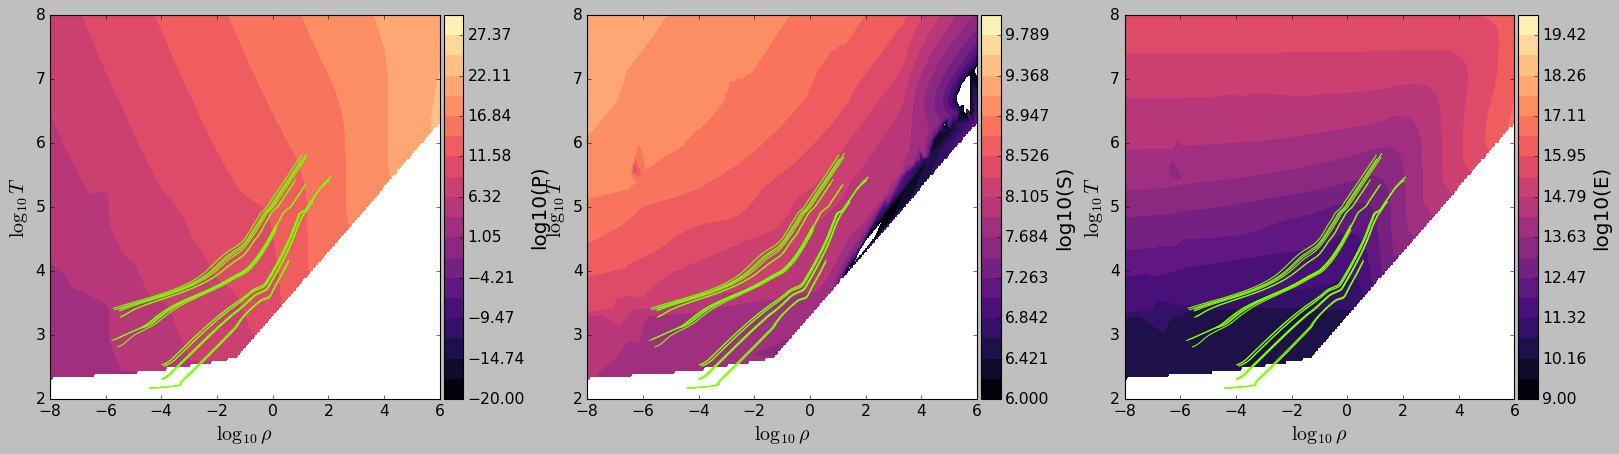

In [161]:

control_H = meos.simple_table()
control_H.X = 1.
control_H.Y = 0.
control_H.Z = 0.
control_H.log10Tgrid = cms19_H.log10Tgrid
control_H.log10rhogrid = cms19_H.log10rhogrid
control_H.log10Pgrid = np.log10( 10**cms19_H.log10Pgrid - scaling_fac*cms19_H_P_diff )
control_H.log10Sgrid = np.log10( 10**cms19_H.log10Sgrid - scaling_fac*cms19_H_S_diff )
control_H.log10Ugrid = np.log10( 10**cms19_H.log10Egrid - scaling_fac*cms19_H_E_diff )
control_H.log10Egrid = control_H.log10Ugrid
control_H.compute_atomic_number()
#control_H.compute_F(F_smoothing_kernel=smoothing_kernel)

meos.contourf_sublots_with_colorbars(nRow=1, nCol=3, 
                                xs=control_H.log10rhogrid,
                                ys=control_H.log10Tgrid,
                                zs=[control_H.log10Pgrid,control_H.log10Sgrid,control_H.log10Egrid],
                                xlims=(-8,6),
                                ylims=(2,8),
                                zlims=[(-20,30),(6,10),(9,20)],
                                levels=20,
                                xlabels=r'$\log_{10}\rho$',
                                ylabels=r'$\log_{10}T$',
                                zlabels=['log10(P)','log10(S)','log10(E)'],
                                cmap='magma', vlines=None, hlines=None, otherlines_x=[prof['logRho'] for prof in profiles], otherlines_y=[prof['logT'] for prof in profiles], 
                                species='H', plot_interpolation_lines=False, savename=None)


control_He = meos.simple_table()
control_He.X = 0.
control_He.Y = 1.
control_He.Z = 0.
control_He.log10Tgrid = cms19_He.log10Tgrid
control_He.log10rhogrid = cms19_He.log10rhogrid
control_He.log10Pgrid = np.log10( 10**cms19_He.log10Pgrid - scaling_fac*cms19_He_P_diff )
control_He.log10Sgrid = np.log10( 10**cms19_He.log10Sgrid - scaling_fac*cms19_He_S_diff )
control_He.log10Ugrid = np.log10( 10**cms19_He.log10Egrid - scaling_fac*cms19_He_E_diff )
control_He.log10Egrid = control_He.log10Ugrid
control_He.compute_atomic_number()
nanmask = np.isnan(control_He.log10Pgrid) | np.isnan(control_He.log10Sgrid) | np.isnan(control_He.log10Egrid)
control_He.log10Pgrid[nanmask] = np.nan
control_He.log10Sgrid[nanmask] = np.nan
control_He.log10Egrid[nanmask] = np.nan

control_He.log10Pgrid = meos.fill_in_nans(control_He.log10Pgrid, control_He)
control_He.log10Sgrid = meos.fill_in_nans(control_He.log10Sgrid, control_He)
control_He.log10Egrid = meos.fill_in_nans(control_He.log10Egrid, control_He)
#control_He.compute_F(F_smoothing_kernel=smoothing_kernel)

meos.contourf_sublots_with_colorbars(nRow=1, nCol=3, 
                                xs=control_He.log10rhogrid,
                                ys=control_He.log10Tgrid,
                                zs=[control_He.log10Pgrid,control_He.log10Sgrid,control_He.log10Egrid],
                                xlims=(-8,6),
                                ylims=(2,8),
                                zlims=[(-20,30),(6,10),(9,20)],
                                levels=20,
                                xlabels=r'$\log_{10}\rho$',
                                ylabels=r'$\log_{10}T$',
                                zlabels=['log10(P)','log10(S)','log10(E)'],
                                cmap='magma', vlines=None, hlines=None, otherlines_x=[prof['logRho'] for prof in profiles], otherlines_y=[prof['logT'] for prof in profiles], 
                                species='He', plot_interpolation_lines=False, savename=None)


control_Z = meos.simple_table()
control_Z.X = 0.
control_Z.Y = 0.
control_Z.Z = 1.
control_Z.log10Tgrid = Z.log10Tgrid
control_Z.log10rhogrid = Z.log10rhogrid
control_Z.log10Pgrid = np.log10( 10**Z.log10Pgrid - scaling_fac*Z_P_diff )
control_Z.log10Sgrid = np.log10( 10**Z.log10Sgrid - scaling_fac*Z_S_diff )
control_Z.log10Ugrid = np.log10( 10**Z.log10Egrid - scaling_fac*Z_E_diff )
control_Z.log10Egrid = control_Z.log10Ugrid
control_Z.compute_atomic_number()

nanmask = np.isnan(control_Z.log10Pgrid) | np.isnan(control_Z.log10Sgrid) | np.isnan(control_Z.log10Egrid)
control_Z.log10Pgrid[nanmask] = np.nan
control_Z.log10Sgrid[nanmask] = np.nan
control_Z.log10Egrid[nanmask] = np.nan

control_Z.log10Pgrid = meos.fill_in_nans(control_Z.log10Pgrid, control_Z)
control_Z.log10Sgrid = meos.fill_in_nans(control_Z.log10Sgrid, control_Z)
control_Z.log10Egrid = meos.fill_in_nans(control_Z.log10Egrid, control_Z)

#control_Z.compute_F(F_smoothing_kernel=smoothing_kernel)


meos.contourf_sublots_with_colorbars(nRow=1, nCol=3, 
                                xs=control_Z.log10rhogrid,
                                ys=control_Z.log10Tgrid,
                                zs=[control_Z.log10Pgrid,control_Z.log10Sgrid,control_Z.log10Egrid],
                                xlims=(-8,6),
                                ylims=(2,8),
                                zlims=[(-20,30),(6,10),(9,20)],
                                levels=20,
                                xlabels=r'$\log_{10}\rho$',
                                ylabels=r'$\log_{10}T$',
                                zlabels=['log10(P)','log10(S)','log10(E)'],
                                cmap='magma', vlines=None, hlines=None, otherlines_x=[prof['logRho'] for prof in profiles], otherlines_y=[prof['logT'] for prof in profiles], 
                                species='Z', plot_interpolation_lines=False, savename=None)



/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/1206553552.py:4: RuntimeWarning: overflow encountered in power
  zs=[10**cms19_H.F_log10Pgrid/10**cms19_H.log10Pgrid,10**cms19_H.F_log10Sgrid/10**cms19_H.log10Sgrid,10**cms19_H.F_log10Egrid/10**cms19_H.log10Ugrid,
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/1206553552.py:5: RuntimeWarning: overflow encountered in power
  10**control_H.log10Pgrid/10**cms19_H.log10Pgrid,10**control_H.log10Sgrid/10**cms19_H.log10Sgrid,10**control_H.log10Egrid/10**cms19_H.log10Ugrid],
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/1206553552.py:5: RuntimeWarning: invalid value encountered in divide
  10**control_H.log10Pgrid/10**cms19_H.log10Pgrid,10**control_H.log10Sgrid/10**cms19_H.log10Sgrid,10**control_H.log10Egrid/10**cms19_H.log10Ugrid],


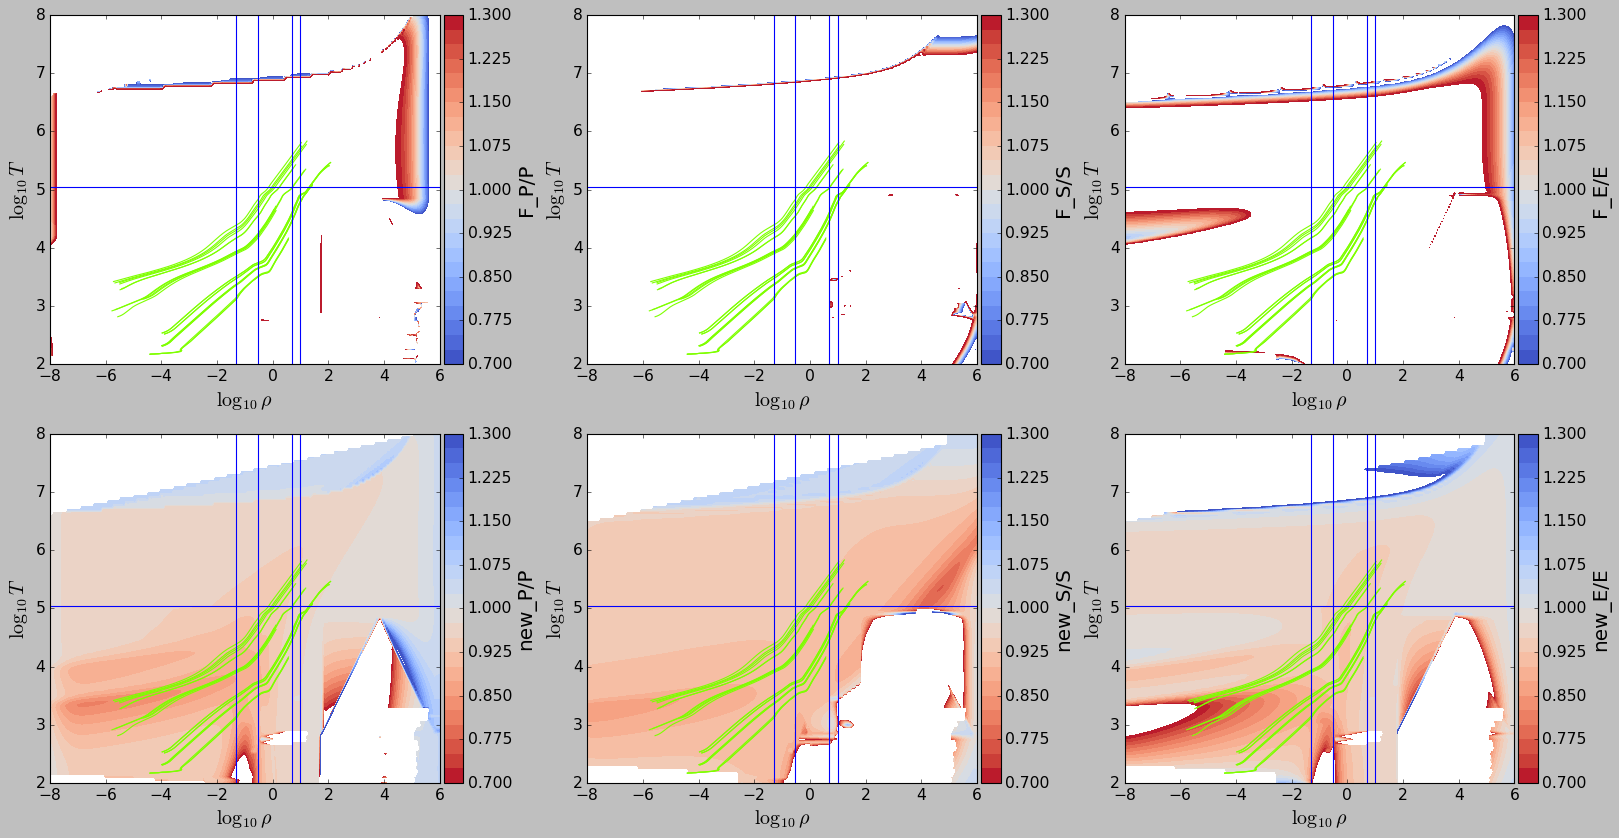

In [162]:
meos.contourf_sublots_with_colorbars(nRow=2, nCol=3, 
                                xs=cms19_H.log10rhogrid,
                                ys=cms19_H.log10Tgrid,
                                zs=[10**cms19_H.F_log10Pgrid/10**cms19_H.log10Pgrid,10**cms19_H.F_log10Sgrid/10**cms19_H.log10Sgrid,10**cms19_H.F_log10Egrid/10**cms19_H.log10Ugrid,
                                    10**control_H.log10Pgrid/10**cms19_H.log10Pgrid,10**control_H.log10Sgrid/10**cms19_H.log10Sgrid,10**control_H.log10Egrid/10**cms19_H.log10Ugrid],
                                xlims=(-8,6),
                                ylims=(2,8),
                                zlims=[(0.7,1.3),(0.7,1.3),(0.7,1.3),(0.7,1.3),(0.7,1.3),(0.7,1.3)],
                                #zlims=None,
                                levels=25,
                                xlabels=r'$\log_{10}\rho$',
                                ylabels=r'$\log_{10}T$',
                                zlabels=['F_P/P','F_S/S','F_E/E','new_P/P','new_S/S','new_E/E'],
                                cmap=['coolwarm','coolwarm','coolwarm','coolwarm_r','coolwarm_r','coolwarm_r'], vlines=None, hlines=None, otherlines_x=[prof['logRho'] for prof in profiles], otherlines_y=[prof['logT'] for prof in profiles], 
                                species='H', plot_interpolation_lines=True, savename=None)

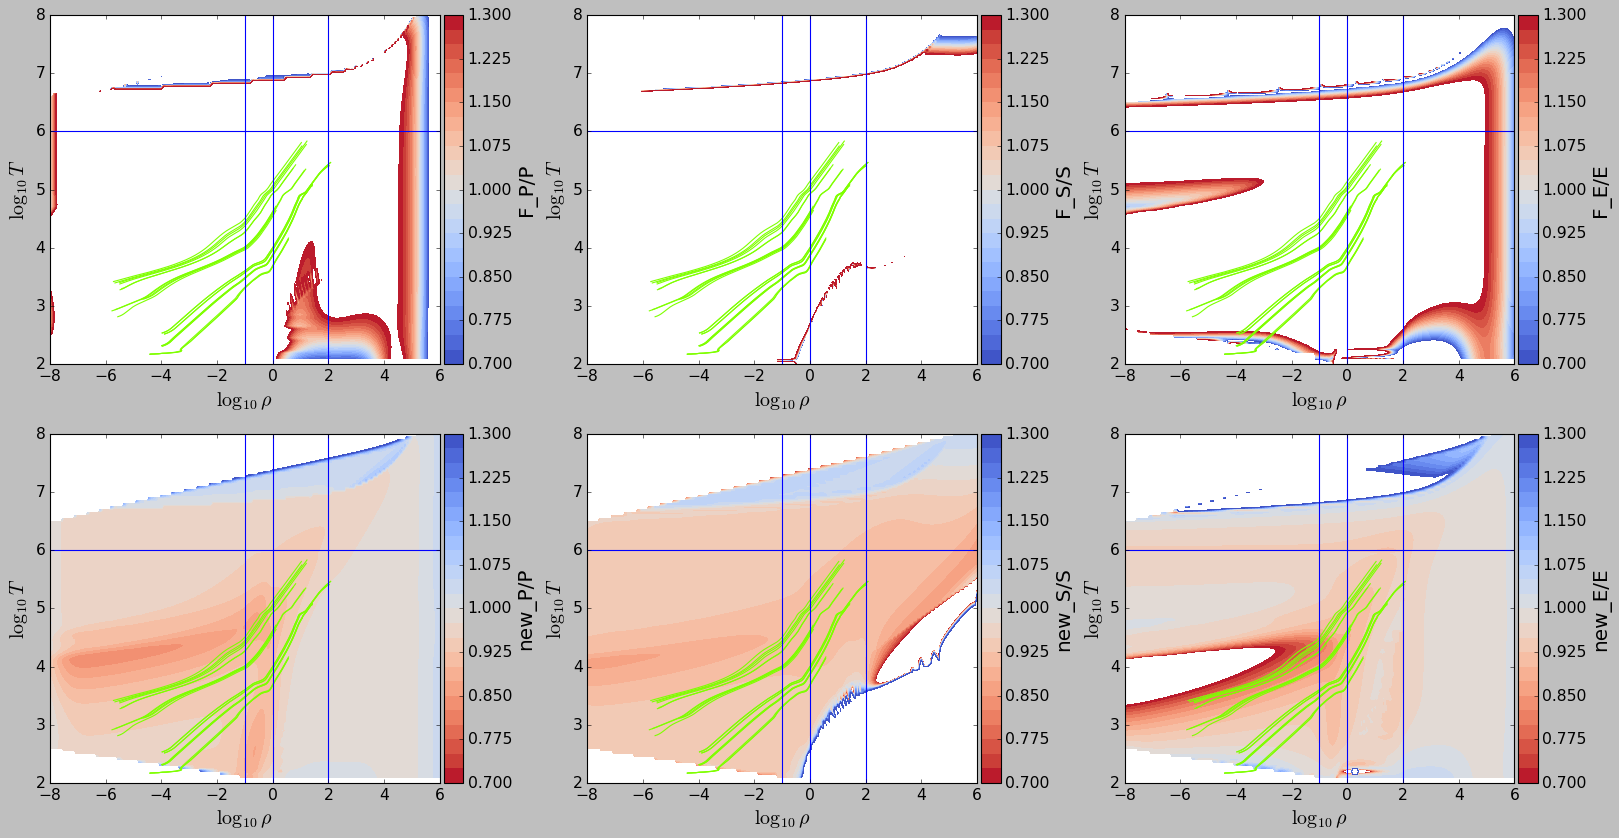

In [163]:
meos.contourf_sublots_with_colorbars(nRow=2, nCol=3, 
                                xs=cms19_He.log10rhogrid,
                                ys=cms19_He.log10Tgrid,
                                zs=[10**cms19_He.F_log10Pgrid/10**cms19_He.log10Pgrid,10**cms19_He.F_log10Sgrid/10**cms19_He.log10Sgrid,10**cms19_He.F_log10Egrid/10**cms19_He.log10Ugrid,
                                    10**control_He.log10Pgrid/10**cms19_He.log10Pgrid,10**control_He.log10Sgrid/10**cms19_He.log10Sgrid,10**control_He.log10Egrid/10**cms19_He.log10Ugrid],
                                xlims=(-8,6),
                                ylims=(2,8),
                                zlims=[(0.7,1.3),(0.7,1.3),(0.7,1.3),(0.7,1.3),(0.7,1.3),(0.7,1.3)],
                                #zlims=None,
                                levels=25,
                                xlabels=r'$\log_{10}\rho$',
                                ylabels=r'$\log_{10}T$',
                                zlabels=['F_P/P','F_S/S','F_E/E','new_P/P','new_S/S','new_E/E'],
                                cmap=['coolwarm','coolwarm','coolwarm','coolwarm_r','coolwarm_r','coolwarm_r'], vlines=None, hlines=None, otherlines_x=[prof['logRho'] for prof in profiles], otherlines_y=[prof['logT'] for prof in profiles], 
                                species='He', plot_interpolation_lines=True, savename=None)

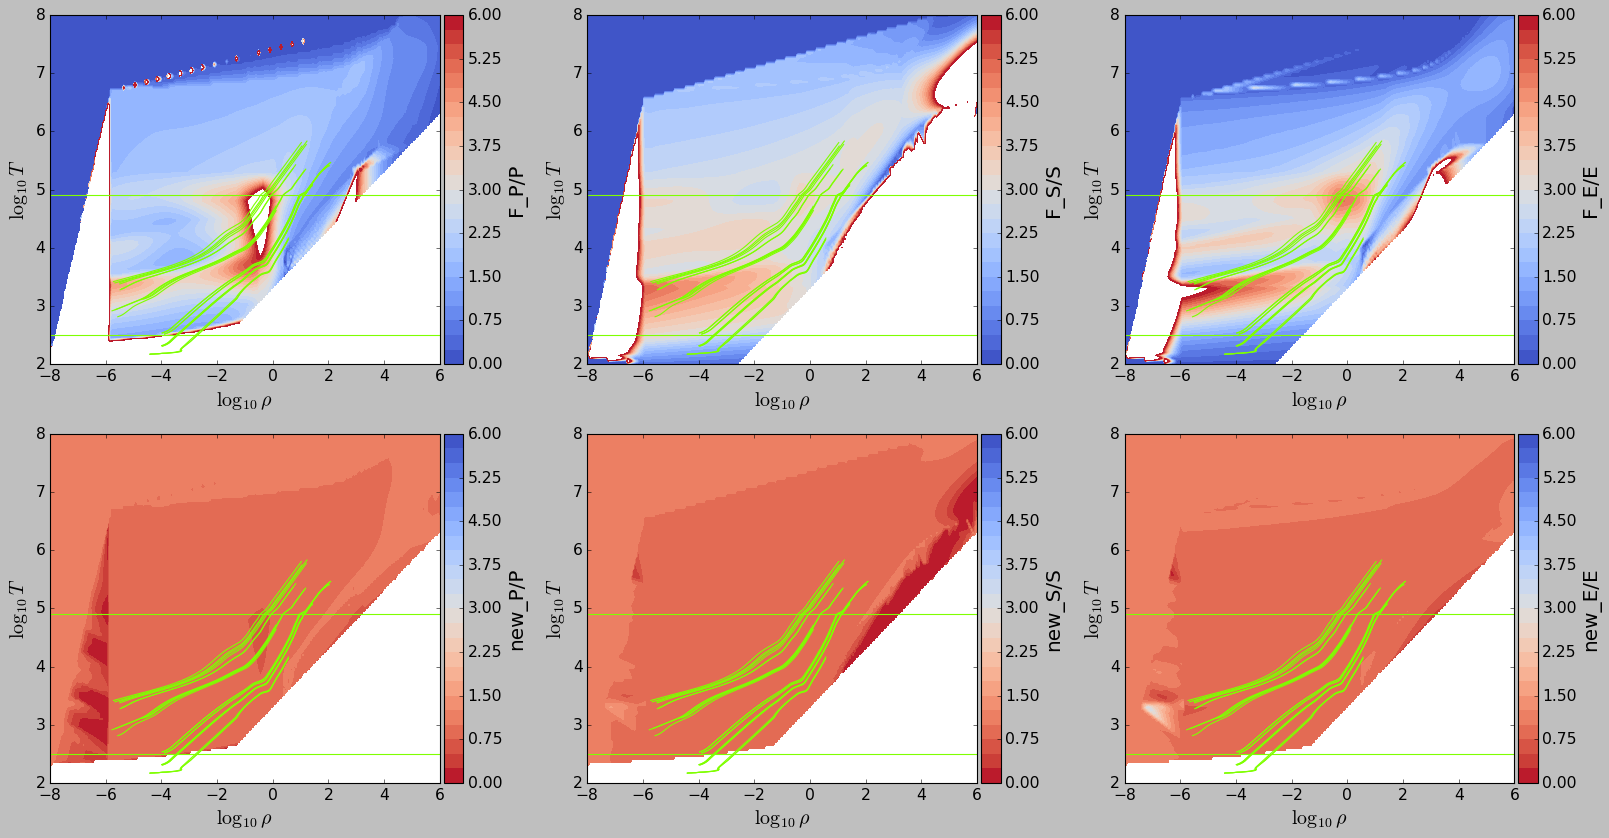

In [164]:
meos.contourf_sublots_with_colorbars(nRow=2, nCol=3, 
                                xs=Z.log10rhogrid,
                                ys=Z.log10Tgrid,
                                zs=[10**Z.F_log10Pgrid/10**Z.log10Pgrid,10**Z.F_log10Sgrid/10**Z.log10Sgrid,10**Z.F_log10Egrid/10**Z.log10Ugrid,
                                    10**control_Z.log10Pgrid/10**Z.log10Pgrid,10**control_Z.log10Sgrid/10**Z.log10Sgrid,10**control_Z.log10Egrid/10**Z.log10Ugrid],
                                xlims=(-8,6),
                                ylims=(2,8),
                                zlims=(0,6),
                                #zlims=None,
                                levels=25,
                                xlabels=r'$\log_{10}\rho$',
                                ylabels=r'$\log_{10}T$',
                                zlabels=['F_P/P','F_S/S','F_E/E','new_P/P','new_S/S','new_E/E'],
                                cmap=['coolwarm','coolwarm','coolwarm','coolwarm_r','coolwarm_r','coolwarm_r'], vlines=None, hlines=[2.5,4.9], otherlines_x=[prof['logRho'] for prof in profiles], otherlines_y=[prof['logT'] for prof in profiles], 
                                species='Z', plot_interpolation_lines=True, savename=None)

# plot therm. consistency of original, new ("control")

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_11362/1713403084.py:4: RuntimeWarning: overflow encountered in power
  10**cms19_H.log10Pgrid,10**cms19_H.log10Sgrid,10**cms19_H.log10Egrid,


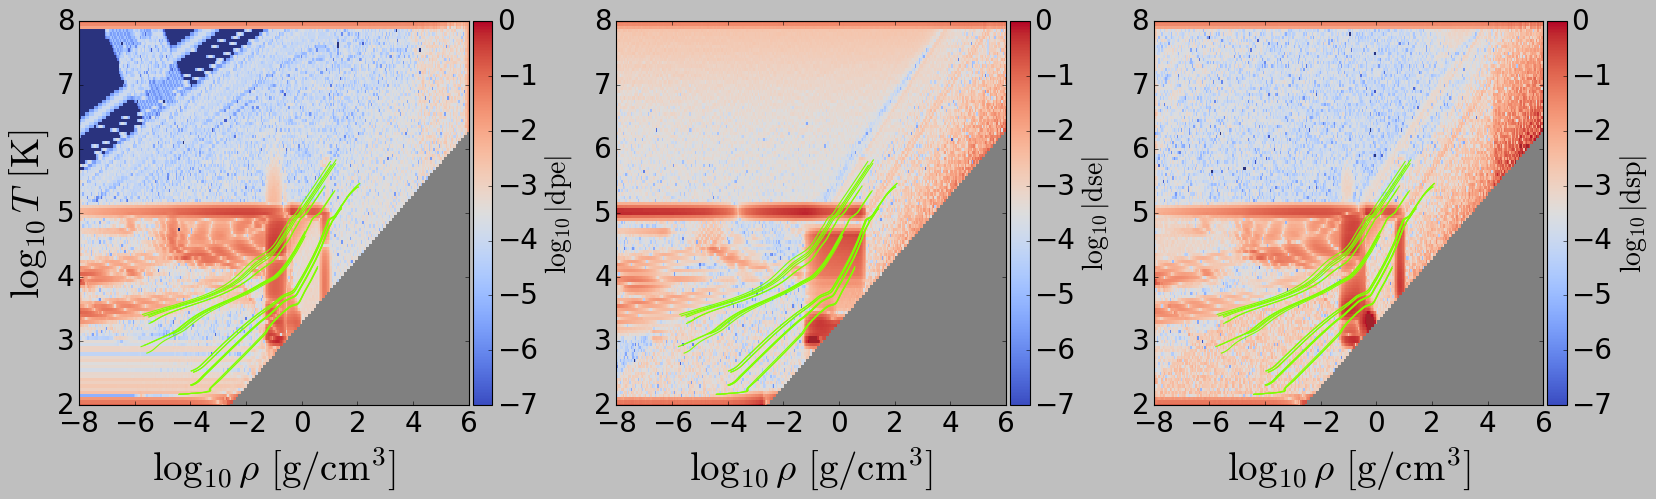

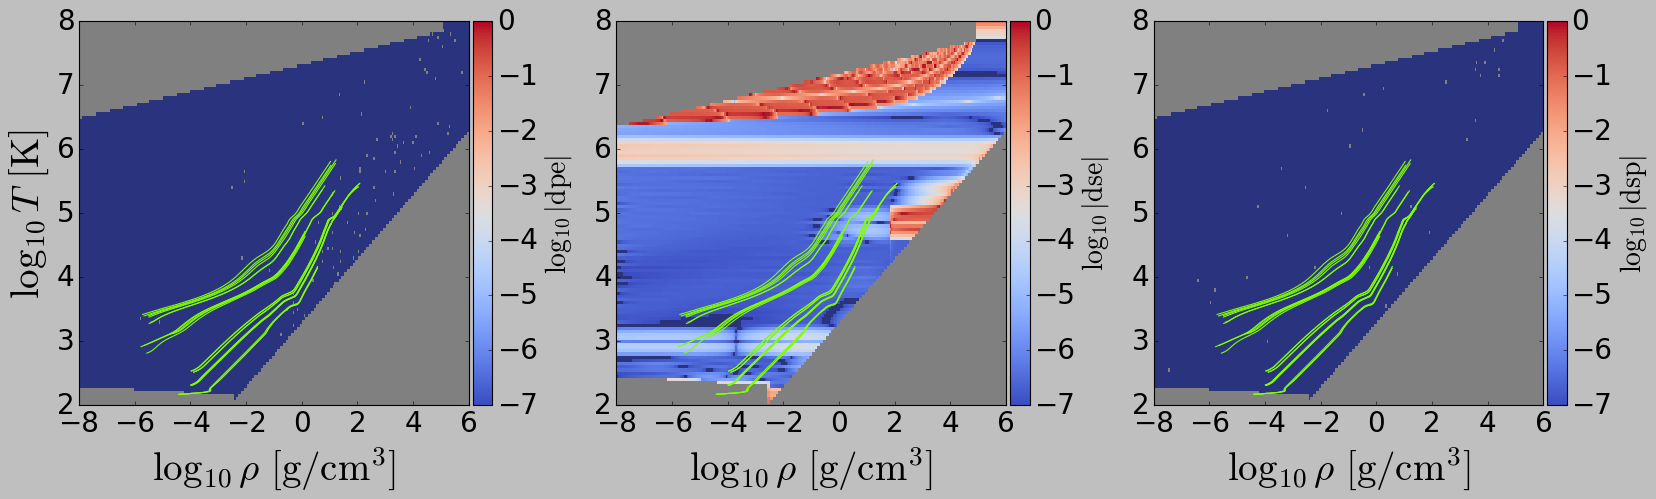

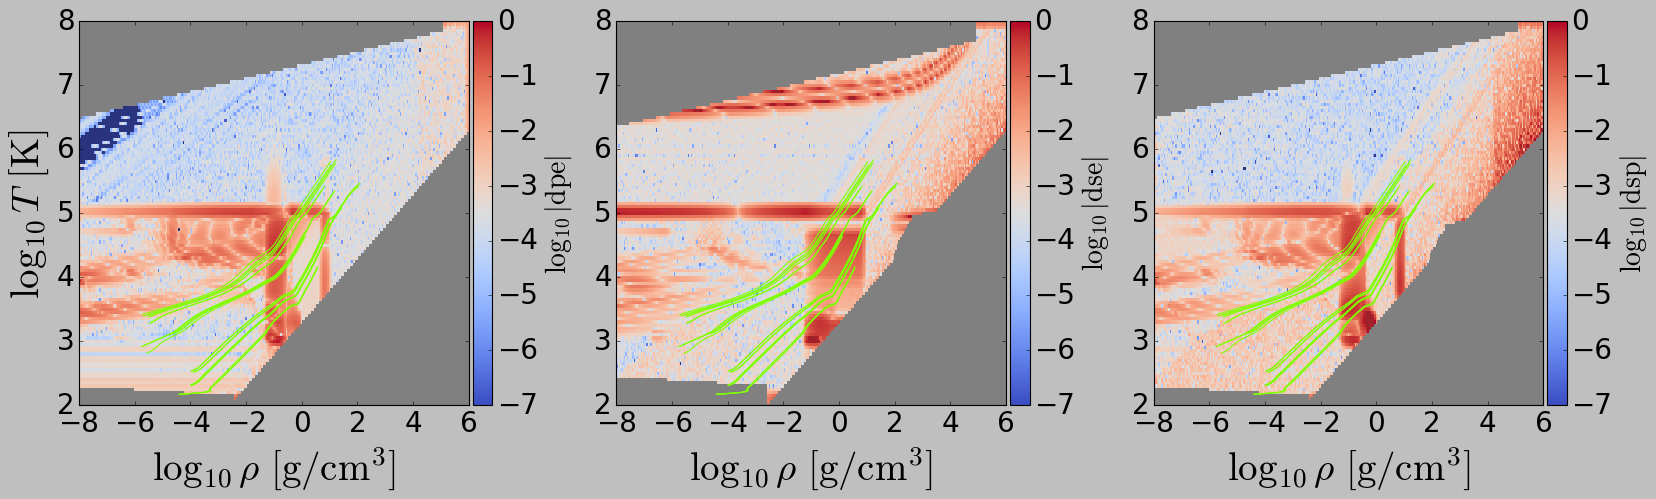

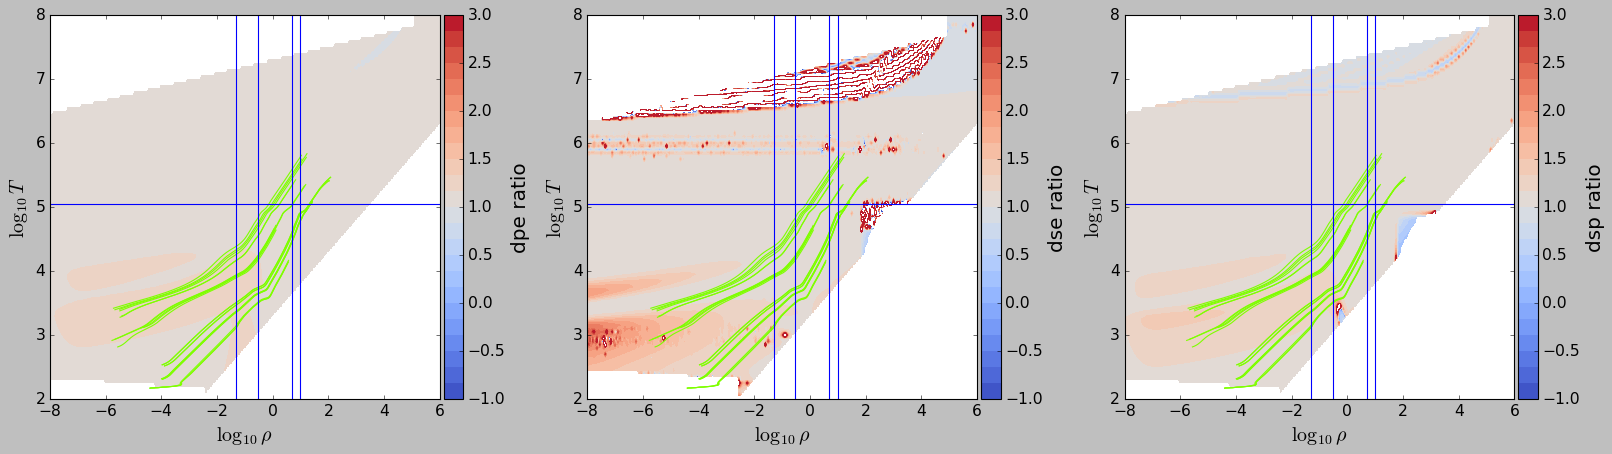

In [165]:
# original

H_dpe, H_dse, H_dsp, H_a, H_b, H_c = meos.consistency_metrics(cms19_H, 
                                                              10**cms19_H.log10Pgrid,10**cms19_H.log10Sgrid,10**cms19_H.log10Egrid,
                                                              species='H',maskUnphysicalRegion=False,
                                                              plot=False,plot_tracks=True,paperplot=True)#, savename="./CMS19_X=1.pdf")

# F version

F_H_dpe, F_H_dse, F_H_dsp, F_H_a, F_H_b, F_H_c = meos.consistency_metrics(cms19_H, 
                                                                          cms19_H.F_Pgrid,cms19_H.F_Sgrid,cms19_H.F_Egrid,
                                                                          species='H',maskUnphysicalRegion=False,
                                                                          plot=False,plot_tracks=True,paperplot=True)#, savename="./CMS19_X=1_F.pdf")

# control
control_H_dpe, control_H_dse, control_H_dsp, control_H_a, control_H_b, control_H_c = meos.consistency_metrics(control_H, 
                                                                          10**control_H.log10Pgrid,10**control_H.log10Sgrid,10**control_H.log10Egrid,
                                                                          species='H',maskUnphysicalRegion=False,
                                                                          plot=False,plot_tracks=True,paperplot=True)#, savename="./CMS19_X=1_F.pdf")


meos.contourf_sublots_with_colorbars(nRow=1, nCol=3, 
                                xs=cms19_H.log10rhogrid,
                                ys=cms19_H.log10Tgrid,
                                zs=[control_H_dpe/H_dpe,control_H_dse/H_dse,control_H_dsp/H_dsp],
                                xlims=(-8,6),
                                ylims=(2,8),
                                zlims=(-1,3),
                                levels=25,
                                xlabels=r'$\log_{10}\rho$',
                                ylabels=r'$\log_{10}T$',
                                zlabels=['dpe ratio', 'dse ratio', 'dsp ratio'],
                                cmap='coolwarm', vlines=None, hlines=None, otherlines_x=[prof['logRho'] for prof in profiles], otherlines_y=[prof['logT'] for prof in profiles], 
                                species='H', plot_interpolation_lines=True, savename=None)

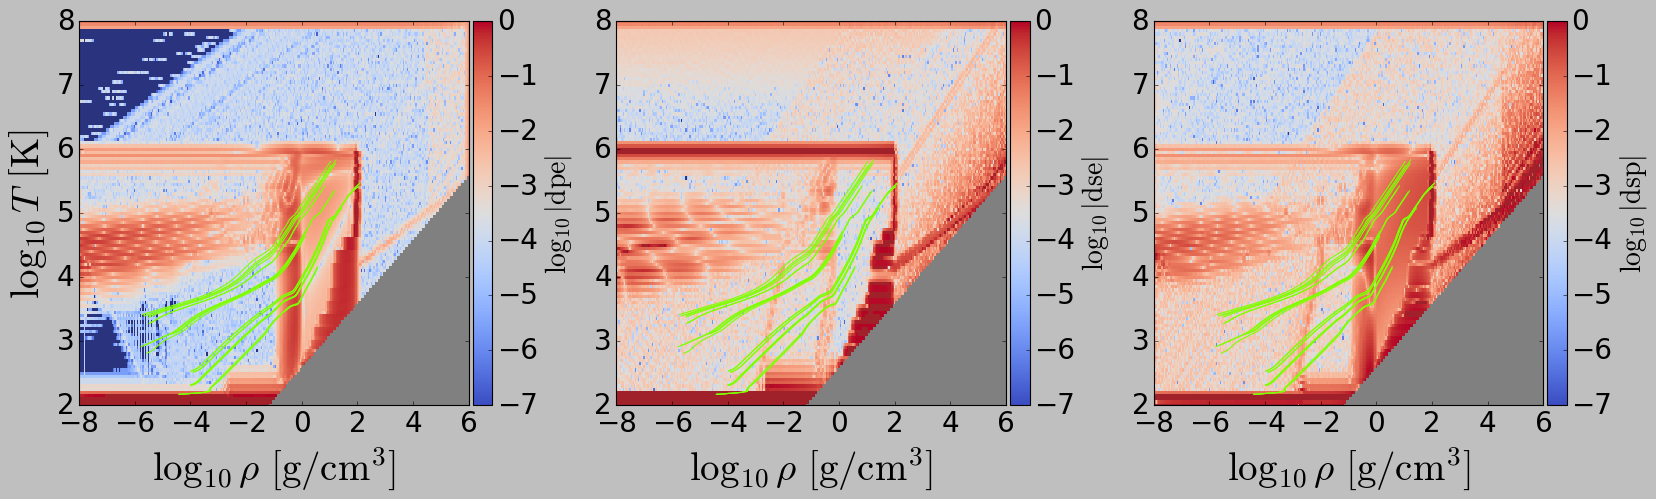

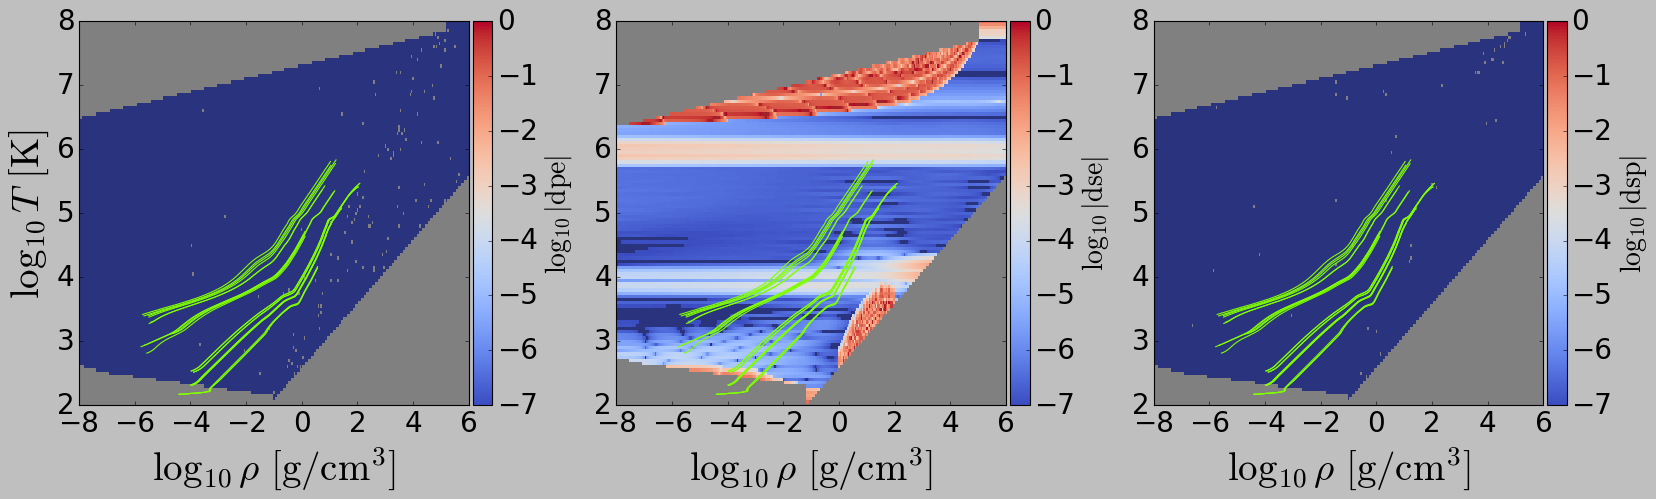

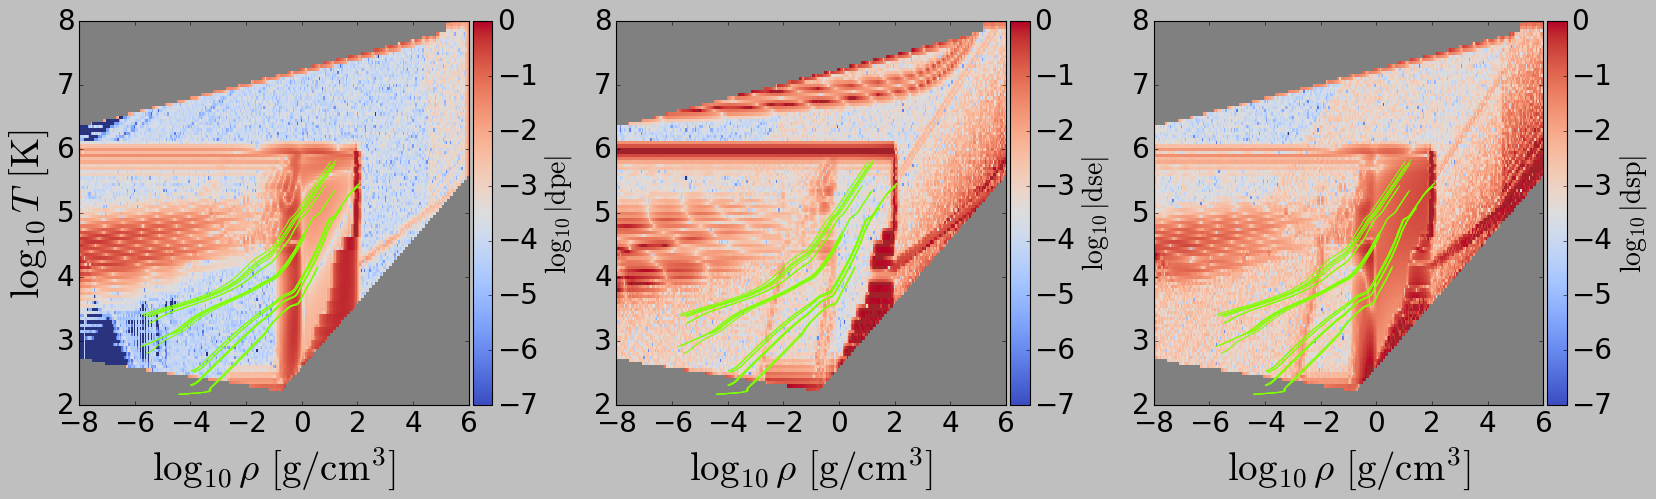

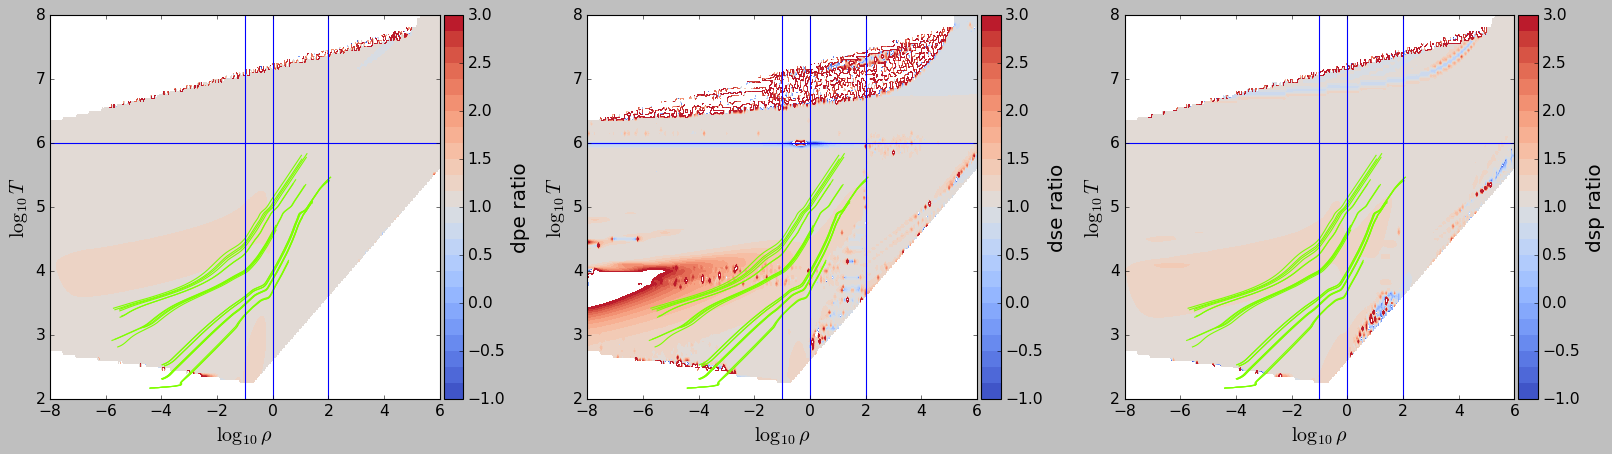

In [166]:
# original

He_dpe, He_dse, He_dsp, He_a, He_b, He_c = meos.consistency_metrics(cms19_He, 
                                                                    10**cms19_He.log10Pgrid,10**cms19_He.log10Sgrid,10**cms19_He.log10Egrid,
                                                                    species='He',maskUnphysicalRegion=False,
                                                                    plot=False,plot_tracks=True, paperplot=True)#,savename="./CMS19_Y=1.pdf")

# F version 
F_He_dpe, F_He_dse, F_He_dsp, F_He_a, HF_e_b, F_He_c = meos.consistency_metrics(cms19_He, 
                                                                    cms19_He.F_Pgrid,cms19_He.F_Sgrid,cms19_He.F_Egrid,
                                                                    species='He',maskUnphysicalRegion=False,
                                                                    plot=False,plot_tracks=True, paperplot=True)#,savename="./CMS19_Y=1_F.pdf")

# control
control_He_dpe, control_He_dse, control_He_dsp, control_He_a, control_He_b, control_He_c = meos.consistency_metrics(control_He, 
                                                                          10**control_He.log10Pgrid,10**control_He.log10Sgrid,10**control_He.log10Egrid,
                                                                          species='He',maskUnphysicalRegion=False,
                                                                          plot=False,plot_tracks=True,paperplot=True)#, savename="./CMS19_X=1_F.pdf")


meos.contourf_sublots_with_colorbars(nRow=1, nCol=3, 
                                xs=cms19_He.log10rhogrid,
                                ys=cms19_He.log10Tgrid,
                                zs=[control_He_dpe/He_dpe,control_He_dse/He_dse,control_He_dsp/He_dsp],
                                xlims=(-8,6),
                                ylims=(2,8),
                                zlims=(-1,3),
                                levels=25,
                                xlabels=r'$\log_{10}\rho$',
                                ylabels=r'$\log_{10}T$',
                                zlabels=['dpe ratio', 'dse ratio', 'dsp ratio'],
                                cmap='coolwarm', vlines=None, hlines=None, otherlines_x=[prof['logRho'] for prof in profiles], otherlines_y=[prof['logT'] for prof in profiles], 
                                species='He', plot_interpolation_lines=True, savename=None)

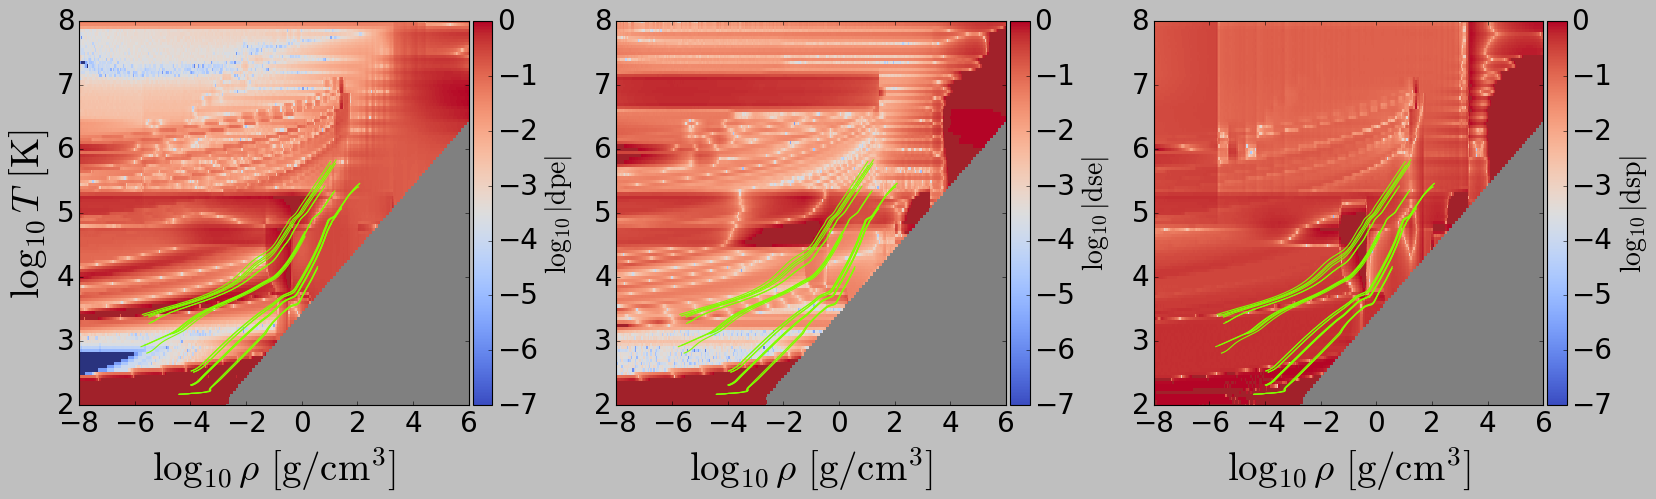

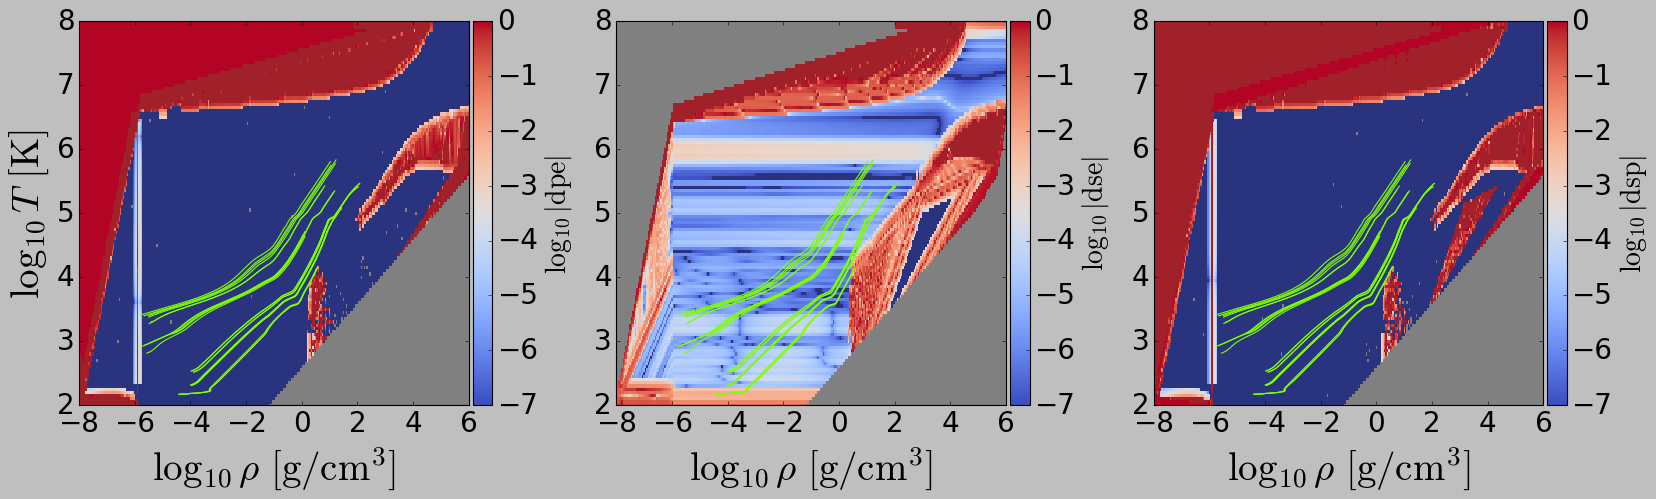

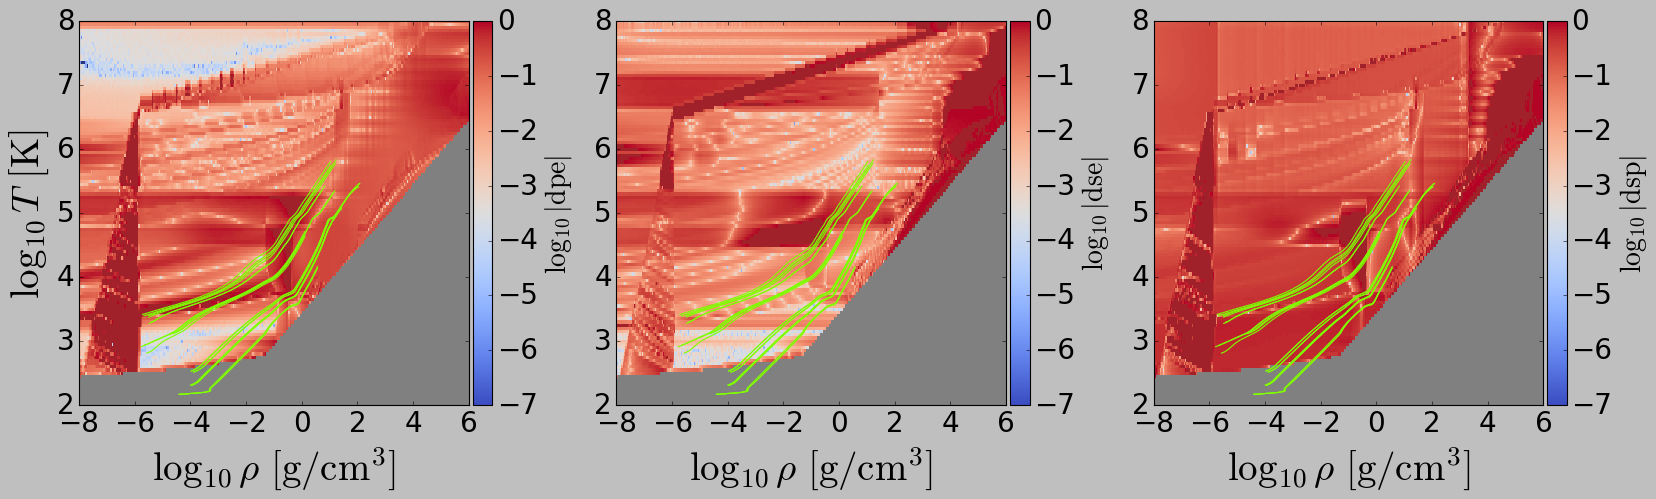

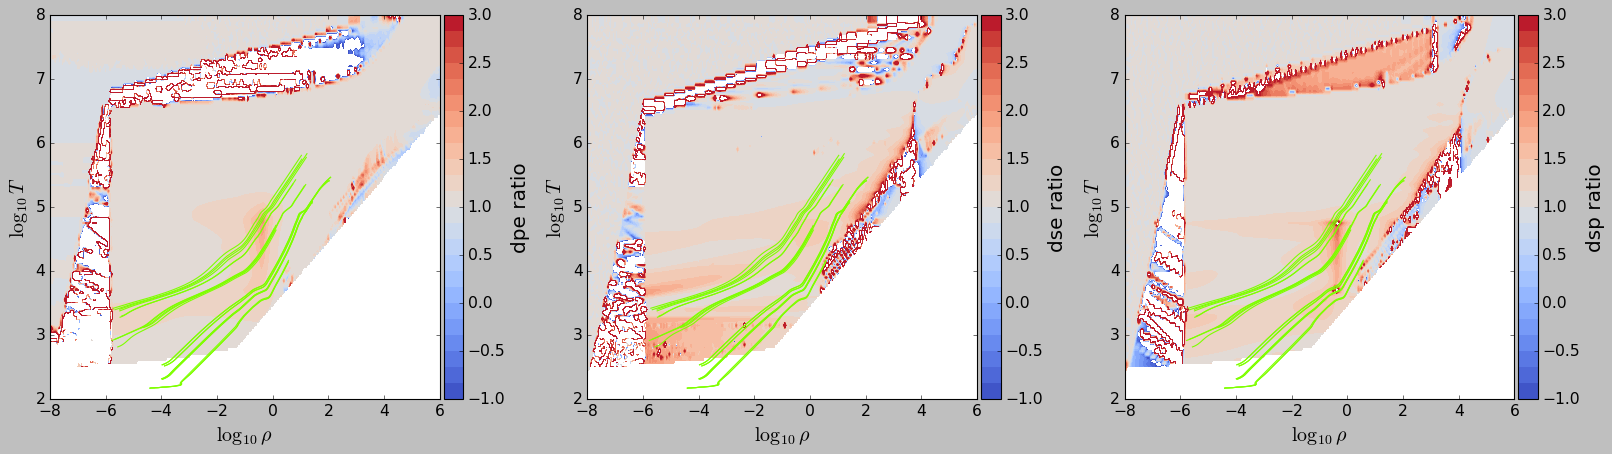

In [167]:
#original

Z_dpe, Z_dse, Z_dsp, Z_a, Z_b, Z_c = meos.consistency_metrics(Z, 
                                                              10**Z.log10Pgrid,10**Z.log10Sgrid,10**Z.log10Ugrid,
                                                              species='H',maskUnphysicalRegion=False,
                                                              plot=False,plot_tracks=True,paperplot=True)#, savename="./Zblend.pdf")

# F version
F_Z_dpe, F_Z_dse, F_Z_dsp, F_Z_a, F_Z_b, F_Z_c = meos.consistency_metrics(Z, 
                                                              Z.F_Pgrid,Z.F_Sgrid,Z.F_Egrid,
                                                              species='H',maskUnphysicalRegion=False,
                                                              plot=False,plot_tracks=True,paperplot=True)#, savename="./Zblend_F.pdf")

# control
control_Z_dpe, control_Z_dse, control_Z_dsp, control_Z_a, control_Z_b, control_Z_c = meos.consistency_metrics(control_Z, 
                                                                          10**control_Z.log10Pgrid,10**control_Z.log10Sgrid,10**control_Z.log10Egrid,
                                                                          species='Z',maskUnphysicalRegion=False,
                                                                          plot=False,plot_tracks=True,paperplot=True)#, savename="./CMS19_X=1_F.pdf")

meos.contourf_sublots_with_colorbars(nRow=1, nCol=3, 
                                xs=Z.log10rhogrid,
                                ys=Z.log10Tgrid,
                                zs=[control_Z_dpe/Z_dpe,control_Z_dse/Z_dse,control_Z_dsp/Z_dsp],
                                xlims=(-8,6),
                                ylims=(2,8),
                                zlims=(-1,3),
                                levels=25,
                                xlabels=r'$\log_{10}\rho$',
                                ylabels=r'$\log_{10}T$',
                                zlabels=['dpe ratio', 'dse ratio', 'dsp ratio'],
                                cmap='coolwarm', vlines=None, hlines=None, otherlines_x=[prof['logRho'] for prof in profiles], otherlines_y=[prof['logT'] for prof in profiles], 
                                species='Z', plot_interpolation_lines=True, savename=None)

# Save results

In [168]:
header='log10T[K] log10P[erg/cm3] log10rho[g/cm3] log10E[erg/g] log10S[erg/g/K]'

In [169]:
# smoothed F-based EoS
H_filename = "tc_CMS19_H_smoothing={0}.txt".format(smoothing_kernel)
H_tosave = np.vstack((np.ravel(cms19_H.log10Tgrid,order='F'),np.ravel(cms19_H.F_log10Pgrid,order='F'),np.ravel(cms19_H.log10rhogrid,order='F'),np.ravel(cms19_H.F_log10Egrid,order='F'),np.ravel(cms19_H.F_log10Sgrid,order='F'))).T
np.savetxt(H_filename, H_tosave, header=header)

He_filename = "tc_CMS19_He_smoothing={0}.txt".format(smoothing_kernel)
He_tosave = np.vstack((np.ravel(cms19_He.log10Tgrid,order='F'),np.ravel(cms19_He.F_log10Pgrid,order='F'),np.ravel(cms19_He.log10rhogrid,order='F'),np.ravel(cms19_He.F_log10Egrid,order='F'),np.ravel(cms19_He.F_log10Sgrid,order='F'))).T
np.savetxt(He_filename, He_tosave, header=header)

Z_filename = "tc_Z_smoothing={0}.txt".format(smoothing_kernel)
Z_tosave = np.vstack((np.ravel(Z.log10Tgrid,order='F'),np.ravel(Z.F_log10Pgrid,order='F'),np.ravel(Z.log10rhogrid,order='F'),np.ravel(Z.F_log10Egrid,order='F'),np.ravel(Z.F_log10Sgrid,order='F'))).T
np.savetxt(Z_filename, Z_tosave, header=header)

In [170]:
# control EoS
H_filename = "control_CMS19_H_smoothing={0}_scalingfac={1}.txt".format(smoothing_kernel,scaling_fac)
H_tosave = np.vstack((np.ravel(control_H.log10Tgrid,order='F'),np.ravel(control_H.log10Pgrid,order='F'),np.ravel(control_H.log10rhogrid,order='F'),np.ravel(control_H.log10Egrid,order='F'),np.ravel(control_H.log10Sgrid,order='F'))).T
np.savetxt(H_filename, H_tosave, header=header)

He_filename = "control_CMS19_He_smoothing={0}_scalingfac={1}.txt".format(smoothing_kernel,scaling_fac)
He_tosave = np.vstack((np.ravel(control_He.log10Tgrid,order='F'),np.ravel(control_He.log10Pgrid,order='F'),np.ravel(control_He.log10rhogrid,order='F'),np.ravel(control_He.log10Egrid,order='F'),np.ravel(control_He.log10Sgrid,order='F'))).T
np.savetxt(He_filename, He_tosave, header=header)

Z_filename = "control_Z_smoothing={0}_scalingfac={1}.txt".format(smoothing_kernel,scaling_fac)
Z_tosave = np.vstack((np.ravel(control_Z.log10Tgrid,order='F'),np.ravel(control_Z.log10Pgrid,order='F'),np.ravel(control_Z.log10rhogrid,order='F'),np.ravel(control_Z.log10Egrid,order='F'),np.ravel(control_Z.log10Sgrid,order='F'))).T
np.savetxt(Z_filename, Z_tosave, header=header)